In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib
import seaborn as sns
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors

import utils
import optimization
from social_learning import Network

font = {'size': 12}
matplotlib.rc('font', **font)

seed = 42
np.random.seed(seed)

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

colors = sns.color_palette("tab10")
colors_dark = sns.color_palette("dark")
font = {'size': 17}
matplotlib.rc('font', **font)

In [3]:
step_size = 0.5 # parameter delta in (0, 1)

In [4]:
er_prob = 0.3
states = 3
multistate = True

clusters_agents = [20, 25, 30]
agents = sum(clusters_agents)
agents = sum(clusters_agents)
clusters_states = [0, 1, 2]
clusters = len(clusters_agents)
probs = 0.05 * np.ones((clusters, clusters))
probs[0,0] = 0.9
probs[1,1] = 0.8
probs[2,2] = 0.9
g = nx.stochastic_block_model(clusters_agents, probs, seed=0)
adj_matrix = nx.adjacency_matrix(g).todense()
adj_matrix = np.array(adj_matrix)

combination_matrix, centrality, connected = utils.generate_combination_weights(adj_matrix, 0)
if not connected:
    raise (ValueError, "Not connected")

state_true = []
states_c = 3
state_size = clusters_agents
for s, c in zip(list(range(states_c)), state_size):
    state_true = state_true + c*[s]
state_true = np.array(state_true)

In [5]:
def plot_mean_kls(pos, kls, clusters_agents):
    cumsum = np.cumsum([0] + clusters_agents)
    kls_mean = np.zeros(len(clusters_agents))
    for i in range(len(clusters_agents)):
        kls_mean[i] = np.mean(kls[cumsum[i]:cumsum[i+1]])
        
    n = len(kls)
    for c, kl in zip(list(range(len(clusters_agents))), kls_mean):
        # p = int(n/clusters*c+1)
        p = np.sum(np.array(clusters_agents)[:c])
        x, y = pos[p]
        plt.text(x, y + 0.1, s=str(round(kl, 3)),
                 bbox=dict(facecolor='white', alpha=0.8),
                 horizontalalignment='center')

def plot_graph(combination_matrix, state_array, kls=None, clusters_agents=None, seed=33):
    np.random.seed(seed)
    state_array = np.array(state_array)
    
    combination_matrix_ = combination_matrix + combination_matrix.T
    adj_matrix = combination_matrix + combination_matrix.T
    adj_matrix[adj_matrix > 0] = 1

    pos = nx.spring_layout(nx.from_numpy_array(adj_matrix))
    G = nx.from_numpy_array(combination_matrix_)
    edges = G.edges()
    weights = [G[u][v]['weight']*5 for u, v in edges]

    plt.figure(figsize=(8, 7))
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors_dark[6], node_size=350)
    nodes.set_edgecolor('black')
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors_dark[-2], node_size=350,
                           nodelist=np.where(state_array==1)[0])
    nodes.set_edgecolor('black')
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors[0], node_size=350,
                           nodelist=np.where(state_array==2)[0])
    nodes.set_edgecolor('black')
    plt.box(False)

    nx.draw_networkx_edges(G, pos=pos, edge_color='black', width=weights)
    
    if kls is not None:
        plot_mean_kls(pos, kls, clusters_agents)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


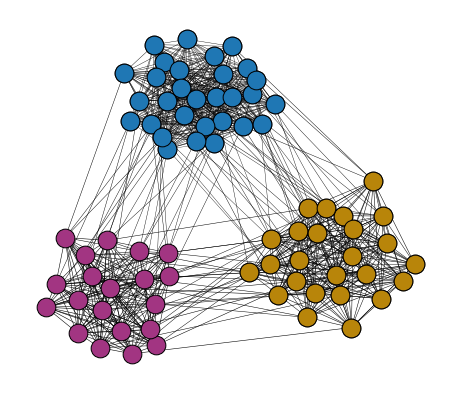

In [6]:
plot_graph(combination_matrix, state_true)

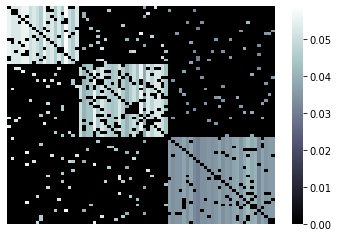

In [7]:
plt.figure()
sns.heatmap(combination_matrix, yticklabels=False, xticklabels=False, cbar=True,
            cmap=sns.color_palette("bone", as_cmap=True))
plt.show()

In [8]:
# generate likelihood parameters
np.random.seed(42)
params = 25
likelihood = np.random.rand(3, params)
likelihood = likelihood/likelihood.sum(1)[:, np.newaxis]

likelihood = np.repeat([likelihood], agents, 0)

In [9]:
kl_matrix = np.zeros((3, 3)) #kl divergence matrix
for s_1 in range(3):
    for s_2 in range(3):
        kl_matrix[s_1,s_2] = utils.kl_divergence(likelihood, s_1, s_2, option=0, state_true=state_true)[np.sum(np.array(clusters_agents)[:s_1])]
print(kl_matrix)

[[0.         0.61840447 0.5203811 ]
 [0.56175868 0.         0.83481305]
 [0.40980307 0.67101193 0.        ]]


In [10]:
initial_belief = np.ones((states, agents))
initial_belief = initial_belief / initial_belief.sum(0)[None, :]
generator = utils.Generator(likelihood, state_true, 0) # random variables generator

In [11]:
'''
procedure initialization
'''
times = 4000
times_skip = 1000
lr = 0.01
window = 4000
state_0 = 0
state_1 = 1

network = Network(agents, states, state_true, adj_matrix, combination_matrix, likelihood, generator,
                  initial_belief, step_size=step_size, window=window+1)
network.step()

if times_skip > 0:
    for _ in range(times_skip):
        network.step()
    network = Network(agents, states, state_true, adj_matrix, combination_matrix, likelihood, generator,
                      network.belief_history[-1], step_size=step_size)
    network.step()

In [12]:
for _ in range(times):
    network.step()

In [13]:
int_beliefs = [network.intermediate_belief_history[i] for i in range(-500, -1)]
int_beliefs = np.array(int_beliefs).mean(0)
state_estimate_psi = utils.state_estimate_psi(int_beliefs)
print(state_estimate_psi)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]


In [14]:
mc_estimation = np.array([network.intermediate_belief_history[i] for i in range(-500, -1)])
mc_estimation = np.argmax(mc_estimation, 1)

mc_true = state_true.reshape(-1, 1).repeat(499, 1).T

mc_estimation = np.equal(mc_estimation, mc_true).mean(0)
mc_estimation = 1 - mc_estimation
print(mc_estimation)

[0.35270541 0.35470942 0.36873747 0.30460922 0.32064128 0.34068136
 0.32064128 0.33466934 0.31863727 0.36072144 0.33066132 0.37074148
 0.33466934 0.3747495  0.3246493  0.43086172 0.35871743 0.34268537
 0.33867735 0.34669339 0.12825651 0.13026052 0.1242485  0.14428858
 0.13827655 0.15831663 0.16432866 0.13827655 0.18236473 0.14629259
 0.14428858 0.15230461 0.15430862 0.12625251 0.17234469 0.13827655
 0.12625251 0.13026052 0.17034068 0.13827655 0.14028056 0.13627255
 0.13226453 0.13426854 0.15430862 0.19839679 0.21442886 0.19238477
 0.21643287 0.23647295 0.21843687 0.21042084 0.24248497 0.23046092
 0.21442886 0.21843687 0.2004008  0.18036072 0.21242485 0.21242485
 0.20641283 0.18637275 0.22044088 0.19438878 0.19839679 0.18036072
 0.21843687 0.18637275 0.20440882 0.14629259 0.2745491  0.23046092
 0.23446894 0.21643287 0.22044088]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


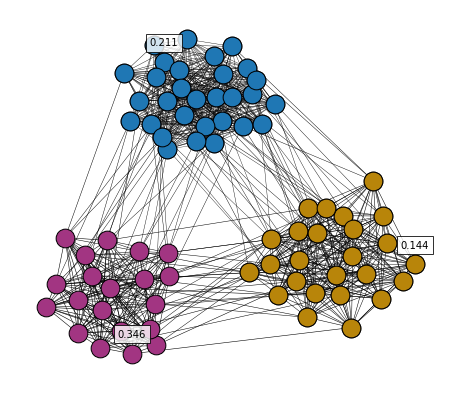

In [15]:
plot_graph(combination_matrix, state_estimate_psi, mc_estimation, clusters_agents)